# Calculate % SFZ in each district

## Purpose
Calculate single-family zoning by House District to understand the impact that the Starter Homes Bill might have on each Representative.

## Approach
- Import Districts
- For each County:
  - Import jurisdiction, map, and text
  - Define and calculate SFZ in text, reduce
  - Join reduced text to map on zone name
  - Clip districts to jurisdiction
  - Calculate district land areas
  - Spatial join map to districts
  - Calculate SFZ areas in districts
  - Calculate median and average minimum lot sizes in districts
  - Calculate % SFZ area by district
  - Return 2 files, spatial and tabular
- Create statewide files from jurisdictions
- Generate high-res categorical map highlighting SFZ areas
- Export "" as image
- Generate high-res choropleth on SFZ %
- Export "" as image
- Generate high-res choropleth on average minimum lot size
- Export "" as image
- Export table with land areas and % by district

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [3]:
house = gpd.read_file('./data/lege/Hawaii_State_House_Districts_2022.geojson')

# keep county, state_house, house_name, geometry
drop_cols = ['objectid', 'house_id',
       'house_abbr', 'st_areashape', 'st_perimetershape']
house = house.drop(drop_cols, axis=1)

# Project to NAD 1983 Albers Hawaii for area calculations https://epsg.io/102007 -- 41s
original_crs = house['geometry'].crs

albers_hi = '+proj=aea +lat_0=13 +lon_0=-157 +lat_1=8 +lat_2=18 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs'
house['geometry'] = house['geometry'].to_crs(albers_hi)

# calculate house area
house['house_area'] = house.area

# project back to other crs
house['geometry'] = house['geometry'].to_crs(original_crs)


In [4]:
# TODO senate = gpd.read_file('./data/lege/Hawaii_State_Senate_Districts_2022.geojson')

In [5]:
# import all jurisdictions - 30s
honolulu = gpd.read_file('./data/zoning_maps/HonoluluCountyHonoluluCountyHI-ZoningDistricts.geojson')
kauai = gpd.read_file('./data/zoning_maps/KauaiCountyKauaiCountyHI-ZoningDistricts.geojson')
maui = gpd.read_file('./data/zoning_maps/MauiCountyMauiCountyHI-ZoningDistricts.geojson')
bigisland = gpd.read_file('./data/zoning_maps/HawaiiCountyHawaiiCountyHI-ZoningDistricts.geojson')

In [6]:
# drop cols, join to statewide
statewide = pd.concat([honolulu, kauai, maui, bigisland])
statewide = statewide[['Jurisdiction','Abbreviated District Name', 'Full District Name', 'Type of Zoning District',
          '1-Family Treatment', '1-Family Max. Height', '1-Family Floor to Area Ratio', '4+-Family Treatment',
          '1-Family Min. Lot', '1-Family Min. # Parking Spaces', 'Accessory Dwelling Unit (ADU) Treatment', 'geometry']]



In [7]:
gdf = house.overlay(statewide, how='intersection')

In [8]:
# project to albers hi
gdf['geometry'] = gdf['geometry'].to_crs(albers_hi)

# calculate zone areas in house districts
gdf['zone_in_house_area'] = gdf.geometry.area

# calculate % area for each zone
gdf['zone_pct'] = gdf['zone_in_house_area'] / gdf['house_area']

# one-hot flag for single-family
# gdf['single_family'] = gdf['Abbreviated District Name'].str.startswith("R-")
gdf['single_family'] = gdf['Abbreviated District Name'].str.match(r"^R-|RS-|RD-|RM-|RA-")

# HI County screwing things up. 
gdf['num_suffix'] = gdf['Abbreviated District Name'].str.findall(r"""(?<=-)\d\.\d|(?<=-)\d+""").str[0].astype(float)

# Logic also includes RM- > 3
gdf.loc[((gdf['Abbreviated District Name'].str.match(r"^RM-")) & (gdf['num_suffix'] < 3.5)), 'single_family'] = False

# https://files.hawaii.gov/dbedt/op/gis/data/cty_zoning_haw.pdf
# https://records.hawaiicounty.gov/weblink/DocView.aspx?dbid=1&id=56156&cr=1

In [9]:
# filter to Residential districts and aggregate to see SF% by district
house_sfz = gdf[gdf['single_family'] == True].groupby('state_house').agg({
    'house_name': 'first',
    'county': 'first',
    'zone_pct': 'sum'
})

# round for clean analysis
house_sfz['zone_pct'] = round(house_sfz['zone_pct'], 3) * 100

# export to file
house_sfz.to_csv('./output/house_sfz.csv')


In [10]:
# join house_sfz percent calculations to house
house_sfz.drop(['house_name', 'county'], axis = 1, inplace=True)

house_plots = house.join(house_sfz, 
           on='state_house', 
           how='left')

house_plots['zone_pct'] = house_plots['zone_pct'].fillna(0)

<Axes: >

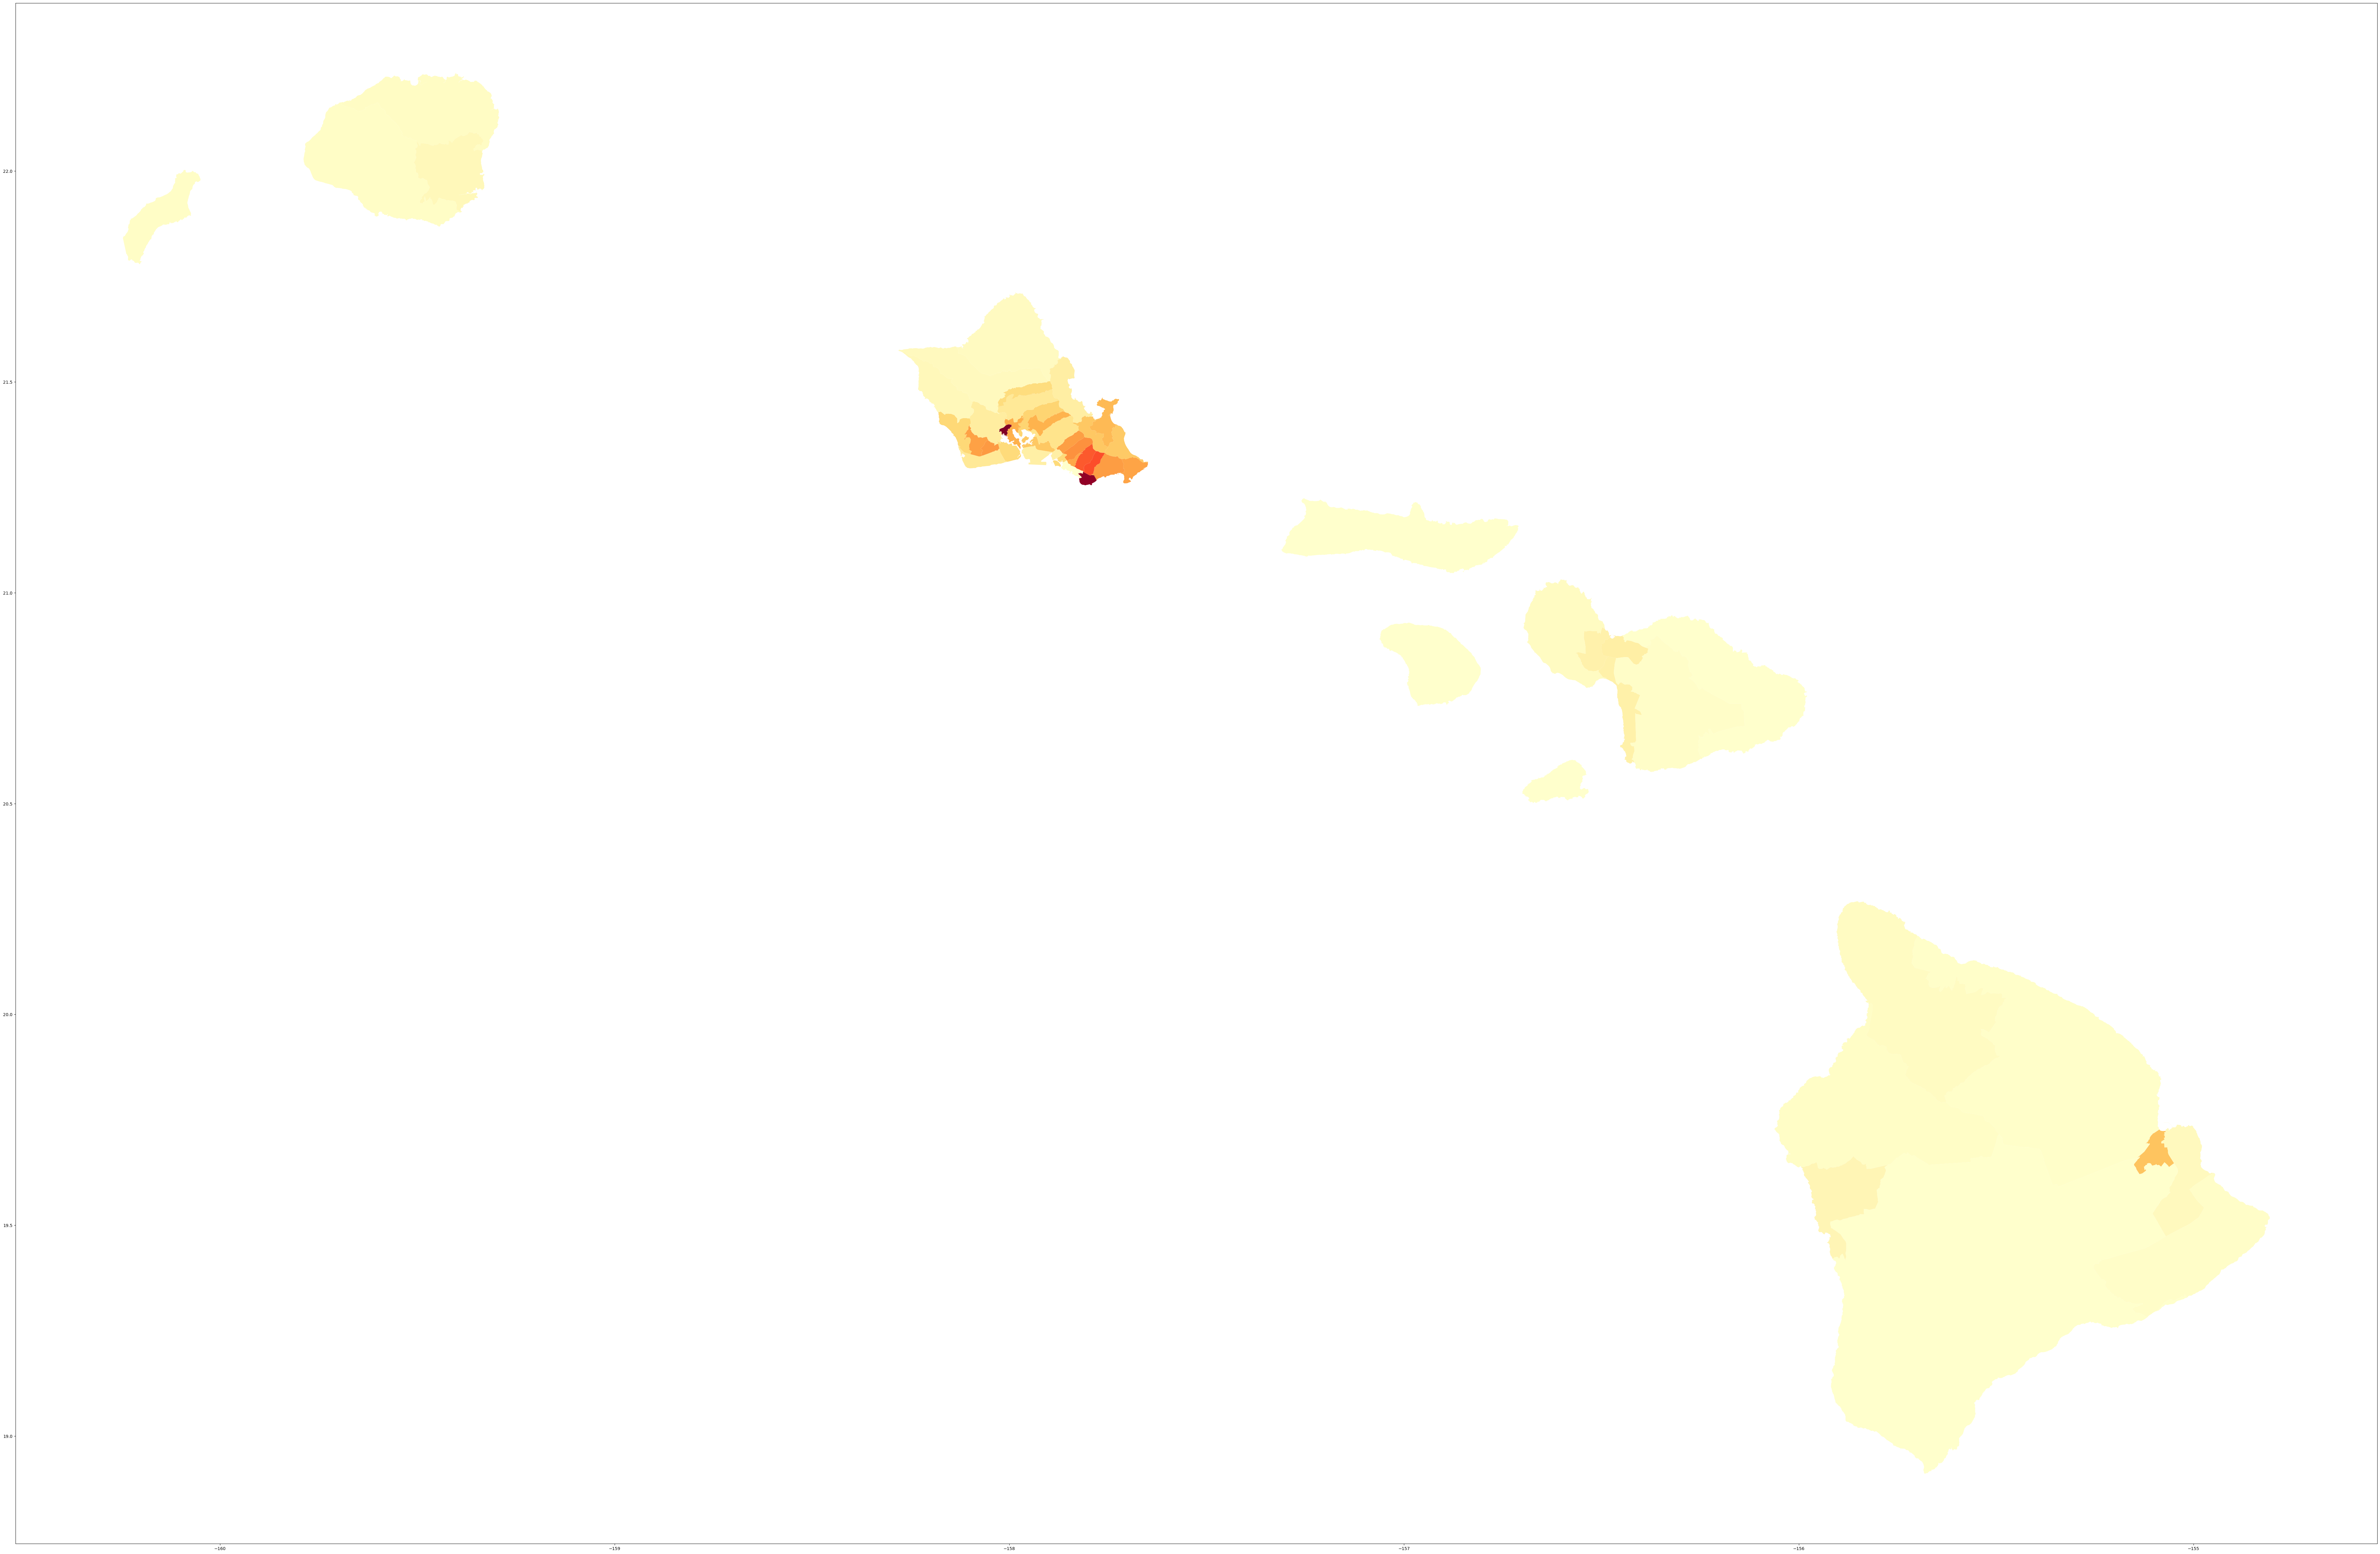

In [11]:
# plot heatmap of zone_pct
house_plots.plot(column='zone_pct', 
           cmap='YlOrRd',
           figsize=(100, 100))

<Axes: xlabel='state_house'>

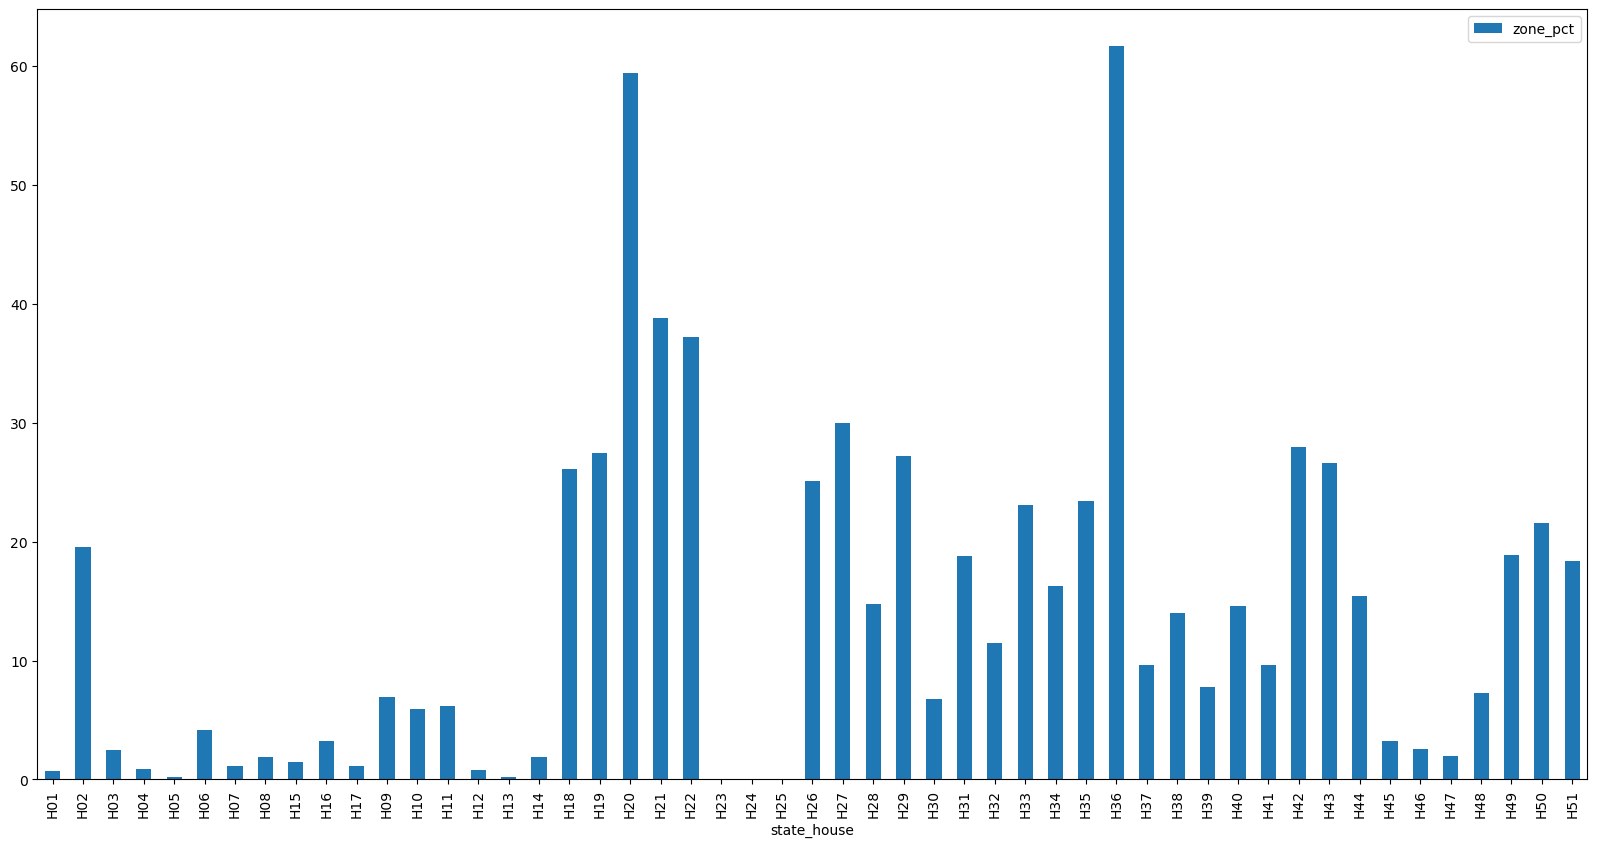

In [12]:
house_plots.plot(kind = 'bar', 
           x = 'state_house', 
           y = 'zone_pct',
           figsize=(20, 10))

<Axes: xlabel='state_house'>

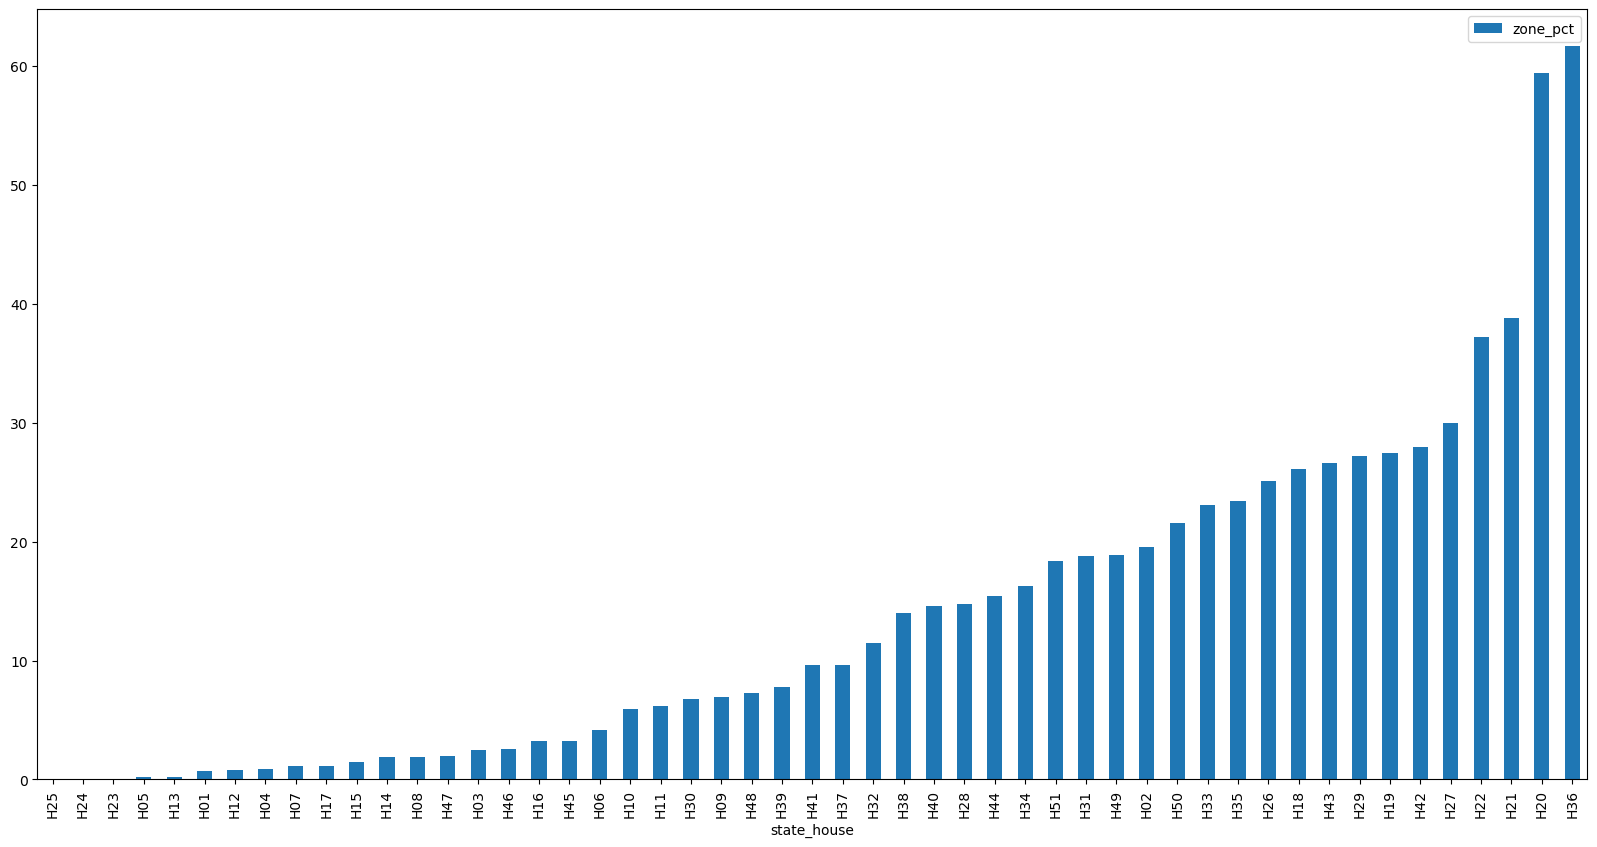

In [13]:
house_plots = house_plots.sort_values('zone_pct')

house_plots.plot(kind = 'bar', 
           x = 'state_house', 
           y = 'zone_pct',
           figsize=(20, 10))

# Single-District Analysis

In [14]:
# function to run any district
def district_analysis(district, data):
    
    print(f'{district} begin  analysis')

    # make folder if necessary
    if not os.path.exists(f'./output/by_district/{district}'):
        os.makedirs(f'./output/by_district/{district}')
    print(f'{district} folder success')

    # filter to district
    df = data[['Abbreviated District Name', 'Full District Name', 'Type of Zoning District', 'zone_pct', 'single_family', 'geometry']][(data['state_house'] == district)]
    # round for clean analysis
    df['zone_pct'] = round(df['zone_pct'], 3) * 100

    # single-family map
    sfplot = df.plot(column = 'single_family', 
              legend = True,
              categorical = True,
              cmap = 'Wistia',
              legend_kwds={"loc": "center right"},
              figsize = (10,10))

    sfplot.set_axis_off()
    sfplot.set_title(f'Single-Family Zoning in District {district}')
    sfplot
    plt.savefig(f'./output/by_district/{district}/{district}_single_family_zoning_map.png')
    print(f'{district} sfplot success')

    # zoning map
    zoneplot = df.plot(column = 'Abbreviated District Name', 
              legend = True,
              categorical = True,
              cmap = 'tab20',
              legend_kwds={"loc": "center right"},
              figsize = (10,10))

    zoneplot.set_axis_off()
    zoneplot.set_title(f'District {district} Zoning Map')
    zoneplot
    plt.savefig(f'./output/by_district/{district}/{district}_zoning_map.png')
    print(f'{district} zoneplot success')

    # bar chart
    df = df.sort_values('zone_pct')
    barchart = df.plot.bar(x = 'Abbreviated District Name',
             y = 'zone_pct')
    barchart
    plt.savefig(f'./output/by_district/{district}/{district}_zoning_bar_chart.png')
    print(f'{district} barchart success')
    
    # export to file
    df = df.drop('geometry', axis = 1)
    df.to_csv(f'./output/by_district/{district}/{district}_zoning_data_table.csv')
    print(f'{district} csv success')

    
    # close all figures
    plt.close('all')
    print(f'{district} end analysis')
    print('')


In [91]:
# iterate over all districts
district_list = house_sfz.index.to_list()
result = (district_analysis(x, gdf) for x in district_list)
list(result)

# for district in gdf['state_house'].to_list():
#     district_analysis(district, gdf)

H01 begin  analysis
H01 folder success
H01 sfplot success
H01 zoneplot success
H01 barchart success
H01 csv success
H01 end analysis

H02 begin  analysis
H02 folder success
H02 sfplot success
H02 zoneplot success
H02 barchart success
H02 csv success
H02 end analysis

H03 begin  analysis
H03 folder success
H03 sfplot success
H03 zoneplot success
H03 barchart success
H03 csv success
H03 end analysis

H04 begin  analysis
H04 folder success
H04 sfplot success
H04 zoneplot success
H04 barchart success
H04 csv success
H04 end analysis

H05 begin  analysis
H05 folder success
H05 sfplot success
H05 zoneplot success
H05 barchart success
H05 csv success
H05 end analysis

H06 begin  analysis
H06 folder success
H06 sfplot success
H06 zoneplot success
H06 barchart success
H06 csv success
H06 end analysis

H07 begin  analysis
H07 folder success
H07 sfplot success
H07 zoneplot success
H07 barchart success
H07 csv success
H07 end analysis

H08 begin  analysis
H08 folder success
H08 sfplot success
H08 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
# Turns out ADUs prohibited in SFH areas is fairly rare, so will not analyze ADU policy
# gdf[((gdf['Accessory Dwelling Unit (ADU) Treatment'] == 'Prohibited') & (gdf['single_family'] == True))]

In [ ]:
# TODO average and median minimum lot size

# TODO % zoned for 1 house + an ADU

In [96]:
# # filter to Residential districts and aggregate to see SF% by district
# house_sfz = gdf.groupby(['state_house', 'Type of Zoning District']).agg({
#     'house_name': 'first',
#     'county': 'first',
#     'house_area': 'first',
#     'zone_in_house_area': 'sum',
#     'zone_pct': 'sum'
# })

# # export to file
# house_sfz = house_sfz.to_csv('./output/house_sfz.csv')
